In [ ]:
"""
Binary-MNIST (6 vs 8) — Width scan without training
===================================================
* No network training (only random initialization, averaged over multiple seeds)
* Metrics:
    m      = ⟨ sign(logit1 − logit0) ⟩            # (8 → +1)
    |m|    = ensemble average of |m|
"""
import math, csv, numpy as np, torch, matplotlib.pyplot as plt
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from typing import Optional
from matplotlib.backends.backend_pdf import PdfPages

import torch
torch.set_default_dtype(torch.float64)

# ─────────────────────────── Device ────────────────────────────
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ──────────────────────── Data: MNIST 6 vs 8 ───────────────────
def load_mnist_6v8(
    root: str = "./data",
    balance: bool = True,
    batch_size: int = 512,
    seed: int = 42,
    device: Optional[torch.device] = None,
):
    """Return the DataLoader for 6 vs 8 and the complete test tensors (for full-batch inference)."""
    device = device or torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tfm = transforms.ToTensor()

    train = datasets.MNIST(root, train=True,  download=True, transform=tfm)
    test  = datasets.MNIST(root, train=False, download=True, transform=tfm)

    def _keep_6_8(ds):
        mask = (ds.targets == 6) | (ds.targets == 8)
        ds.data, ds.targets = ds.data[mask], ds.targets[mask]
        ds.targets = (ds.targets == 8).long()  # 8->1, 6->0
        return ds

    train, test = map(_keep_6_8, (train, test))

    if balance:
        rng = np.random.default_rng(seed)
        def _balance(ds):
            idx0 = torch.where(ds.targets == 0)[0].numpy()
            idx1 = torch.where(ds.targets == 1)[0].numpy()
            n = min(len(idx0), len(idx1))
            keep = np.concatenate([rng.choice(idx0, n, replace=False),
                                   rng.choice(idx1, n, replace=False)])
            rng.shuffle(keep)
            return Subset(ds, torch.from_numpy(keep))
        train, test = map(_balance, (train, test))

    train_ld = DataLoader(train, batch_size=batch_size, shuffle=False)
    test_x, test_y = next(iter(DataLoader(test, batch_size=len(test))))
    return train_ld, test_x.to(device), test_y.to(device)

train_ld, TEST_X, TEST_Y = load_mnist_6v8(device=DEV)
print(f"train samples = {len(train_ld.dataset)}, test samples = {len(TEST_Y)}")
print("device:", TEST_X.device)



100%|██████████| 9.91M/9.91M [00:00<00:00, 36.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.04MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.65MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.87MB/s]


train samples = 11702, test samples = 1916
device: cuda:0


In [ ]:
# ─────────────────────────── Model ─────────────────────────────
class FC(nn.Module):
    """Fully connected MLP: ReLU nonlinearity; input 784; fixed hidden layer width; output 2 (6 vs 8)"""
    def __init__(self, depth: int, width: int, sig_w: float, sig_b2: float = 0.05):
        super().__init__(); layers = []
        scale_in = sig_w / math.sqrt(784)
        inp = nn.Linear(784, width)
        nn.init.normal_(inp.weight, 0, scale_in)
        nn.init.normal_(inp.bias,   0, math.sqrt(sig_b2))
        layers += [inp, nn.ReLU()]   # ReLU

        scale = sig_w / math.sqrt(width)
        for _ in range(depth - 1):
            h = nn.Linear(width, width)
            nn.init.normal_(h.weight, 0, scale)
            nn.init.normal_(h.bias,   0, math.sqrt(sig_b2))
            layers += [h, nn.ReLU()]   # ReLU

        out = nn.Linear(width, 2)
        nn.init.normal_(out.weight, 0, scale)
        # nn.init.orthogonal_(out.weight, gain=scale)
        nn.init.normal_(out.bias,   0, math.sqrt(sig_b2))
        layers.append(out)
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.net(x)


In [ ]:
@torch.no_grad()
def measure_m(net: nn.Module):
    """回傳 (m, |m|, (logits0_mean, logits0_std, logits1_mean, logits1_std))
    m 為平均 spin：sign(logit1 − logit0)
    """
    logits = net(TEST_X)
    spin   = torch.sign(logits[:, 1] - logits[:, 0])  # +1 for digit-8
    # spin = torch.tanh((logits[:, 1] - logits[:, 0]))
    m      = spin.mean().item()

    # NEW: compute logits[:,0] / logits[:,1] mean / std( numpy.std unbiased=False)
    logits0 = logits[:, 0].detach()
    logits1 = logits[:, 1].detach()
    l0_mean = logits0.mean().item()
    l0_std  = logits0.std(unbiased=False).item()  
    l1_mean = logits1.mean().item()
    l1_std  = logits1.std(unbiased=False).item()

    return m, abs(m), (l0_mean, l0_std, l1_mean, l1_std)


# ───────────────────────── Grid / Config(custom sigma range by depth) ───────────────────────
WIDTH  = 100
SEEDS  = 5
EPS    = 1e-12

SIGMA_SWEEP_MAP = {
    1000:  (1.0, 2.0),
}

DEPTHS = sorted(SIGMA_SWEEP_MAP.keys())
BASE_SIGMAS = np.arange(1.0, 2.0, 0.1)

perL_sigmas  = {D: [] for D in DEPTHS}
perL_Mabs    = {D: [] for D in DEPTHS}
# perL_Binder  = {D: [] for D in DEPTHS}

# CSV
FIELDNAMES = [
    "seed", "width", "depth", "sigma_w", "sigma_w2",
    "m", "m_abs",
    "logits0_mean", "logits0_std", "logits1_mean", "logits1_std" 
]
csv_rows = []
# ─────────────────────── main loop：train( WIDTH， DEPTH×σ_w) ───────────────────────
for i_D, D in enumerate(DEPTHS):
    print(f"[Depth={D}] scanning σ_w ...")

    if D in SIGMA_SWEEP_MAP:
        s_lo, s_hi = SIGMA_SWEEP_MAP[D]
        local_sigmas = list(np.linspace(s_lo, s_hi, 10))  # inclusive of endpoints， 10
    else:
        local_sigmas = list(BASE_SIGMAS)

    local_Us = []

    def run_one_sigma(sigma):
        m_samples = []
        for seed in range(SEEDS):
            torch.manual_seed(seed)
            net = FC(D, WIDTH, sigma).to(DEV).eval()

            m, m_abs, (l0_mean, l0_std, l1_mean, l1_std) = measure_m(net)

            csv_rows.append({
                "seed":     seed,
                "width":    WIDTH,
                "depth":    D,
                "sigma_w":  f"{sigma:.5f}",
                "sigma_w2": f"{sigma**2:.5f}",
                "m":        f"{m:.5f}",
                "m_abs":    f"{m_abs:.5f}",
                "logits0_mean": f"{l0_mean:.6f}",
                "logits0_std":  f"{l0_std:.6f}",
                "logits1_mean": f"{l1_mean:.6f}",
                "logits1_std":  f"{l1_std:.6f}",
            })
            m_samples.append(m)
    
        Mabs_mean = float(np.mean(np.abs(m_samples)))
        return Mabs_mean

    for sigma in local_sigmas:
        Mabs_mean = run_one_sigma(float(sigma))
        perL_sigmas[D].append(float(sigma))
        perL_Mabs[D].append(Mabs_mean)

# === output CSV(long-form table，each seed row) ===
out_csv = "scan_depth_sigma_binder_adaptive.csv"
with open(out_csv, "w", newline="", encoding="utf-8") as f:
    writer = csv.DictWriter(f, fieldnames=FIELDNAMES)
    writer.writeheader()
    writer.writerows(csv_rows)
print(f"Saved CSV → {out_csv}")


[Depth=1000] scanning σ_w ...
Done computing Binder cumulant for all (Depth, σ_w).
Saved CSV → scan_depth_sigma_binder_adaptive.csv


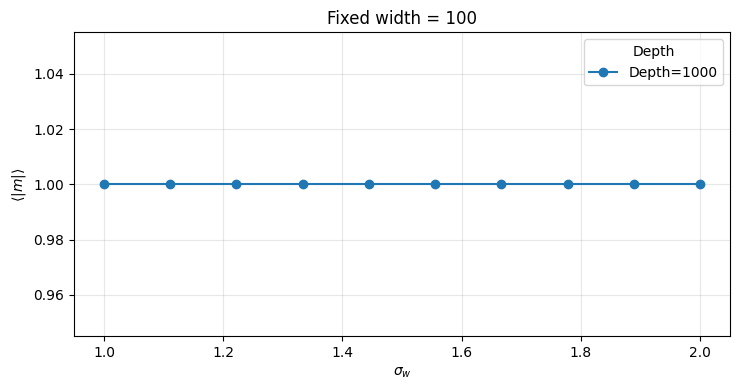

In [ ]:
# === ：<|m|>(each L σ grid) ===
fig, ax = plt.subplots(figsize=(7.5, 4.0))
for D in DEPTHS:
    ax.plot(perL_sigmas[D], perL_Mabs[D], marker="o", label=f"Depth={D}")
ax.set_xlabel(r"$\sigma_w$")
ax.set_ylabel(r"$\langle |m| \rangle$")
ax.set_title(f"Fixed width = {WIDTH}")
ax.grid(True, alpha=0.3)
ax.legend(title="Depth", ncol=2)
plt.tight_layout()
plt.savefig("mabs.png", dpi=160)
plt.show()